In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
from keras.layers import (BatchNormalization,
                         LeakyReLU, 
                         Conv2DTranspose,
                         Conv2D,
                         Dropout,
                         Activation,
                         Input,
                         Concatenate)
from keras.models import Model
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.preprocessing.image import ImageDataGenerator

In [4]:
ma=1000
mi=500
data_file="D:/Data/Datasets/cyprus/dataset.npz"

In [23]:
rad_path="D:/Data/Datasets/cyprus/radpic_1/"
cod_path="D:/Data/Datasets/cyprus/codpic_1/"

left = 34
top = 10
right = 712
bottom = 545
rad_data=[]
cod_data=[]
i=0
for img in os.listdir(rad_path):
    i=i+1
    if i>ma:
        break
    if i>mi:
        image_path=rad_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr = img_arr[left:right,top:bottom]
        img_arr=cv2.resize(img_arr,(256,256), interpolation= cv2.INTER_LINEAR)
        rad_data.append(img_arr)
i=0
for img in os.listdir(cod_path):
    i=i+1
    if i>ma:
        break
    if i>mi:
        image_path=cod_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr = img_arr[left:right,top:bottom]
        img_arr=cv2.resize(img_arr,(256,256), interpolation= cv2.INTER_LINEAR)
        cod_data.append(img_arr)
rad_data=np.array(rad_data)
cod_data=np.array(cod_data)
np.savez_compressed((data_file),rad_data,cod_data)

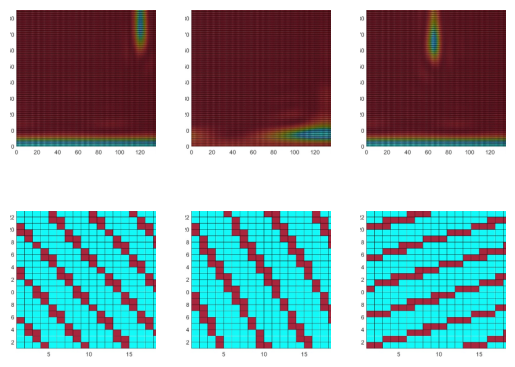

In [5]:
n=3
disp = [np.random.randint(mi,ma) for i in range(n)]
data = np.load(data_file)
rad_data,cod_data=data['arr_0'],data['arr_1']
for i in range(n):
	pyplot.subplot(2, n, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(rad_data[disp[i]-mi].astype('uint8'))
for i in range(n):
	pyplot.subplot(2, n, 1 + n + i)
	pyplot.axis('off')
	pyplot.imshow(cod_data[disp[i]-mi].astype('uint8'))
pyplot.show()

In [6]:
def define_discriminator(image_shape):
	init = RandomNormal(stddev=0.02)
	in_src_image = Input(shape=image_shape)
	in_target_image = Input(shape=image_shape)
	merged = Concatenate()([in_src_image, in_target_image])
	
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	
	model = Model([in_src_image, in_target_image], patch_out)
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [7]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	init = RandomNormal(stddev=0.02)
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	g = LeakyReLU(alpha=0.2)(g)
	return g
 
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	init = RandomNormal(stddev=0.02)
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	g = BatchNormalization()(g, training=True)
	if dropout:
		g = Dropout(0.5)(g, training=True)
	g = Concatenate()([g, skip_in])
	g = Activation('relu')(g)
	return g

def define_generator(image_shape=(256,256,3)):
	init = RandomNormal(stddev=0.02)
	in_image = Input(shape=image_shape)

	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)

	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)

	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)

	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	model = Model(in_image, out_image)
	return model

In [8]:

def define_gan(g_model, d_model, image_shape):
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	in_src = Input(shape=image_shape)
	gen_out = g_model(in_src)
	dis_out = d_model([in_src, gen_out])
	model = Model(in_src, [dis_out, gen_out])
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

In [9]:
def load_real_samples(filename):
	data = np.load(filename)
	X1, X2 = data['arr_0'], data['arr_1']
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [10]:
def generate_real_samples(dataset, n_samples, patch_shape):
	trainA, trainB = dataset
	ix = np.random.randint(0, trainA.shape[0], n_samples)
	X1, X2 = trainA[ix], trainB[ix]
	y = np.ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [11]:
def generate_fake_samples(g_model, samples, patch_shape):
	X = g_model.predict(samples)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [12]:
def summarize_performance(step, g_model, dataset, n_samples=3):
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0

	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])

	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])

	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])

	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()

In [13]:
def train(d_model, g_model, gan_model, dataset, n_epochs=1, n_batch=5):
	n_patch = d_model.output_shape[1]
	trainA, trainB = dataset
	bat_per_epo = int(len(trainA) / n_batch)
	n_steps = bat_per_epo * n_epochs
	print(n_steps)
	for i in range(n_steps):
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		if (i+1) % (bat_per_epo) == 0:
			summarize_performance(i, g_model, dataset)
	msave = 'D:/Data/Datasets/cyprus/gan.h5'
	g_model.compile()
	g_model.save(msave)
	print("Saved and Completed")

In [14]:
dataset = load_real_samples(data_file)
print('Loaded', dataset[0].shape, dataset[1].shape)
image_shape = dataset[0].shape[1:]
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
gan_model = define_gan(g_model, d_model, image_shape)
with tf.device('/gpu:0'):
    train(d_model, g_model, gan_model, dataset)

Loaded (500, 256, 256, 3) (500, 256, 256, 3)


c:\Users\rohit\anaconda3\envs\tf_gpu\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


100
1/1 [==============================] - 7s 7s/step
>1, d1[0.452] d2[0.885] g[74.849]
1/1 [==============================] - 0s 27ms/step
>2, d1[0.330] d2[0.786] g[75.913]
1/1 [==============================] - 0s 25ms/step
>3, d1[0.712] d2[0.450] g[70.642]
1/1 [==============================] - 0s 26ms/step
>4, d1[0.371] d2[0.434] g[71.689]
1/1 [==============================] - 0s 24ms/step
>5, d1[0.306] d2[0.170] g[70.162]
1/1 [==============================] - 0s 24ms/step
>6, d1[0.505] d2[0.219] g[66.778]
1/1 [==============================] - 0s 31ms/step
>7, d1[0.272] d2[0.181] g[67.644]
1/1 [==============================] - 0s 24ms/step
>8, d1[0.205] d2[0.117] g[65.183]
1/1 [==============================] - 0s 23ms/step
>9, d1[0.115] d2[0.100] g[65.409]
1/1 [==============================] - 0s 24ms/step
>10, d1[0.101] d2[0.091] g[64.366]
1/1 [==============================] - 0s 28ms/step
>11, d1[0.287] d2[0.099] g[62.963]
1/1 [==============================] - 0s 25ms/ste

In [15]:
# load and prepare training images
def load_real_samples(filename):
	# load compressed ararys
	data = np.load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [16]:
[X1, X2] = load_real_samples('D:/Data/Datasets/cyprus/dataset.npz')
print('Loaded', X1.shape, X2.shape)
model = tf.keras.models.load_model('D:/Data/Datasets/cyprus/gan.h5')

Loaded (500, 256, 256, 3) (500, 256, 256, 3)


[183]
1/1 [==============================] - 0s 32ms/step


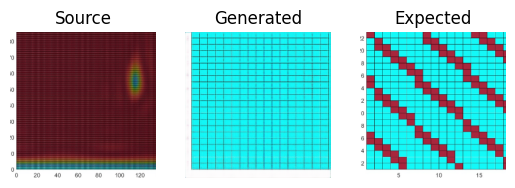

In [20]:
def plot_images(src_img, gen_img, tar_img):
	images = np.vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# show title
		pyplot.title(titles[i])
	pyplot.show()
ix = np.random.randint(0, len(X1), 1)
print(ix)
src_image, tar_image = X1[ix], X2[ix]
gen_image = model.predict(src_image)
plot_images(src_image, gen_image, tar_image)